In [ ]:
#base file path
# path = '/content/drive/Shareddrives/Soft Computing Project'
path = '/content/drive/Shareddrives/soft computing project test'
basepath = path

In [ ]:
from google.colab import drive           # For mounting Google Drive
import os                                 # For file and directory operations
import cv2                                # For image processing
import numpy as np                        # For numerical operations
import pandas as pd                       # For data manipulation and analysis
from sklearn.cluster import KMeans        # For clustering
import tensorflow as tf                   # For deep learning
from tensorflow.keras.applications import VGG16  # For using pre-trained VGG16 model
from tensorflow.keras.applications.vgg16 import preprocess_input  # For preprocessing inputs for VGG16
from tensorflow.keras.models import Model, load_model  # For loading models
from tensorflow.keras import layers, models  # For creating models
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.metrics import confusion_matrix  # For evaluating models
import seaborn as sns                    # For data visualization
import matplotlib.pyplot as plt           # For plotting images
from tensorflow.keras import backend as K  # For backend operations
import gc                                 # For garbage collection
from imblearn.over_sampling import SMOTE   # For oversampling imbalanced datasets
from sklearn.utils import shuffle          # For shuffling data
from glob import glob                     # For file pattern matching
import matplotlib.patches as patches
import matplotlib.pyplot as plt



# Mount Google Drive
drive.mount('/content/drive')
driveLocation = path
%cd $driveLocation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/soft computing project test


# General Functions

In [ ]:
def load_images_from_folder(folder_path):
    dataset = np.load(folder_path)
    return dataset['images'], dataset['image_files']

In [ ]:
#function to display images by cluster
def plot_images_by_cluster(images, image_files, clusters, num_clusters, num_images_to_display=10):
    for cluster_num in range(num_clusters):
        cluster_indices = np.where(clusters == cluster_num)[0]
        num_images = len(cluster_indices)

        # Create a figure to show images
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Cluster {cluster_num + 1} (Total images: {num_images})')

        # Randomly select images to display
        selected_indices = np.random.choice(cluster_indices, size=min(num_images_to_display, num_images), replace=False)

        # Display selected images in the cluster
        for i, idx in enumerate(selected_indices):
            plt.subplot(2, 5, i + 1)
            plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV) to RGB for display
            plt.title(f'Image: {image_files[idx]}')
            plt.axis('off')
        plt.show()

In [ ]:
#function to load the clusters
def get_clusters(image_files, input_file='cluster_assignments.csv'):
    df = pd.read_csv(input_file)
    # map the clusters back to the provided image files
    cluster_dict = dict(zip(df['Image File'], df['Cluster']))

    # ensure clusters are returned in the same order as image_files
    clusters = [cluster_dict[img] for img in image_files]

    return clusters

# Define the model

In [ ]:
def simple_CNN_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='sigmoid', input_shape=(80, 80, 3)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(32, (3, 3), activation='sigmoid'))
    model.add(layers.Conv2D(32, (3, 3), activation='sigmoid'))
    model.add(layers.Conv2D(32, (3, 3), activation='sigmoid'))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='sigmoid'))
    model.add(layers.Conv2D(32, (3, 3), activation='sigmoid'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))


    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output (ship or no ship)

    # Print model summary
    model.summary()

    return model

# Train and Test the model on full color images

## Train the model

### get the clusters

In [ ]:
#load images from the unlabeled dataset
unlabeled_dataset_folder = os.path.join(path, 'dataset.npz')
images, image_files = load_images_from_folder(unlabeled_dataset_folder)

In [ ]:
# Let's assume cluster 0 corresponds to 'no ship' and cluster 1 corresponds to 'ship'

#get the clusters
clusters = get_clusters(image_files, 'cluster_assignments_kmeans.csv')

# Convert labels to a binary format (0 or 1)
labels = np.array(clusters)  # Cluster 0 as 'no ship', Cluster 1 as 'ship'


#count how many images are in each class
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} images")


Label 0: 3221 images
Label 1: 779 images


### get the dataset ready for training

In [ ]:
# Split the data into training and a temporary set for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)

# Create SMOTE object
smote = SMOTE(random_state=42)

# For SMOTE to work, your features need to be 2D. Flatten the images if they are 3D.
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Reshape to (num_samples, 80*80*3)

# Apply SMOTE to oversample the minority class
X_resampled, y_resampled = smote.fit_resample(X_train_flattened, y_train)

# Reshape the oversampled images back to their original dimensions
X_train_balanced = X_resampled.reshape(X_resampled.shape[0], 80, 80, 3)  # Reshape back to (num_samples, 80, 80, 3)

# Shuffle the balanced training set
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_resampled, random_state=42)

# Now split the temporary set into validation and test sets (70% val, 30% test of the temp set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

print(f"Number of images in the validation set: {len(X_val)}")
print(f"Number of images in the testing set: {len(X_test)}")
print(f"Number of images in the training set: {len(X_train_balanced)}")


# Create TensorFlow Dataset objects from the NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Normalize the images (scaling between 0 and 1)
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply normalization lazily on each batch
train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)


# Set the batch size and shuffle the training dataset
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Number of images in the validation set: 840
Number of images in the testing set: 360
Number of images in the training set: 4542


### compile and train the model

In [ ]:
#compile the model
model = simple_CNN_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        K.clear_session()  # Clear session
        gc.collect()       # Run garbage collector

batch_size = 32

# Use the callback when training
model.fit(train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[ClearMemory()],

)
# Save the trained model
model.save('ship_classifier_model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 78, 78, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 78, 78, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 76, 76, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 34, 34, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         131,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,897 (698.82 KB)

 Trainable params: 178,705 (698.07 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7635 - loss: 0.4685 - val_accuracy: 0.7964 - val_loss: 1.2072
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9652 - loss: 0.1100 - val_accuracy: 0.7964 - val_loss: 2.1411
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9764 - loss: 0.0697 - val_accuracy: 0.9667 - val_loss: 0.3798
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9779 - loss: 0.0639 - val_accuracy: 0.7964 - val_loss: 1.0874
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9798 - loss: 0.0597 - val_accuracy: 0.9571 - val_loss: 0.1323
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9886 - loss: 0.0421 - val_accuracy: 0.8107 - val_loss: 1.6012
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9759 - loss: 0.0729 - val_accuracy: 0.9560 - val_loss: 0.2601
Epoch 8/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9902 - loss: 0.0287 -

## Evaluate the model

Test Loss: 0.4713
Test Accuracy: 94.44%
Test Precision: 0.94
Test Recall: 0.80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


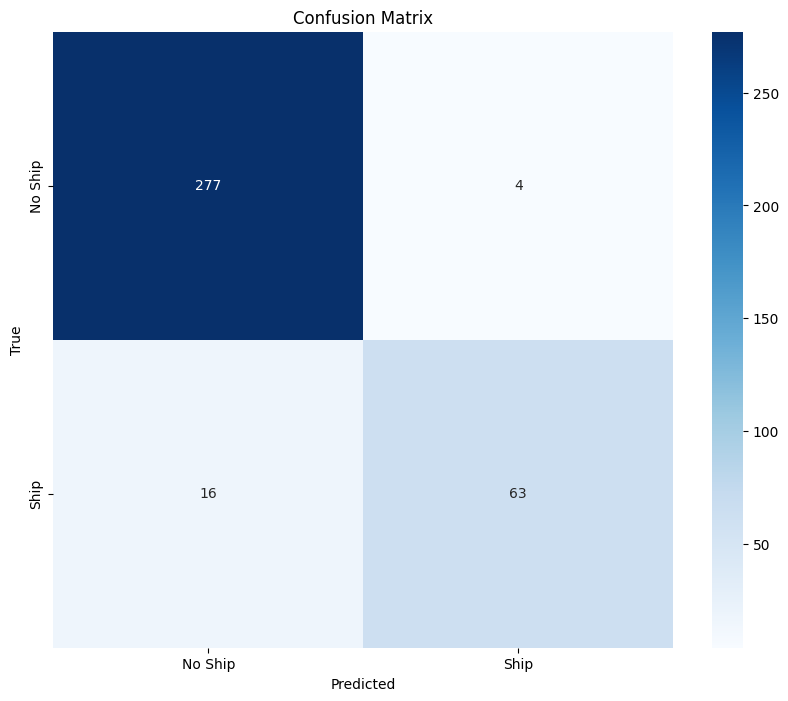

In [ ]:
model = tf.keras.models.load_model('ship_classifier_model1.h5')

# Re-compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])


# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

# Print detailed metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {test_precision:.2f}')
print(f'Test Recall: {test_recall:.2f}')

# Make predictions on the test set
# Use sigmoid thresholding for binary classification
y_pred_prob = model.predict(X_test)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Apply threshold for binary classification
y_true = y_test  # Assuming y_test is already in binary format (0 or 1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Set custom tick labels for the axes
ax.set_xticklabels(['No Ship', 'Ship'])  # Adjust labels as needed
ax.set_yticklabels(['No Ship', 'Ship'])  # Adjust labels as needed

plt.show()

## Test the model on the scene

In [ ]:
# Load the trained model
model = tf.keras.models.load_model('ship_classifier_model1.h5')

basepath = driveLocation  # Using the already defined drive location

# Stride value to move over the image
stride = 20

# List and load the scene file (assuming it follows the same naming pattern)
scene_list = glob(os.path.join(basepath, "sfbay_1*"))
scene_file = scene_list[0]

# Read and convert the image from BGR to RGB
img = cv2.imread(scene_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape

# Create a figure to display the image
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)

# Loop over the image in strides of 20 and process 80x80 patches
for h in range(0, height - 80, stride):
    print("Step", int(h / stride), "of", int((height - 80) / stride))

    # Scan the entire image (from left to right, full width)
    for w in range(0, width - 80, stride):  # Adjusted to scan the full width
        img_box = img[h:h + 80, w:w + 80]
        img_box = np.array([img_box], dtype=np.int64)  # Add batch dimension

        # Get the prediction from the model
        prediction = model.predict(img_box, verbose=False)
        prediction_probability = np.max(prediction)
        prediction_class = np.argmax(prediction)

        # Draw a rectangle based on the predicted class and confidence
        if (prediction_class == 0 and prediction_probability > 0.95) or (prediction_class == 1 and prediction_probability < 0.05):
            ax.add_patch(patches.Rectangle((w, h), 80, 80, edgecolor='r', facecolor='none'))  # Red rectangle for detections

# Show the final image with the detected ships highlighted
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Train and test the model on gray scale images

## Train the model

### get the grayscale clusters

In [ ]:
#load images from the unlabeled dataset
unlabeled_dataset_folder = os.path.join(path, 'dataset.npz')
images, image_files = load_images_from_folder(unlabeled_dataset_folder)

In [ ]:
# Let's assume cluster 0 corresponds to 'no ship' and cluster 1 corresponds to 'ship'

#get the clusters
clusters = get_clusters(image_files, 'cluster_assignments_kmeans_gs.csv')

# Convert labels to a binary format (0 or 1)
labels = np.array(clusters)  # Cluster 0 as 'no ship', Cluster 1 as 'ship'


#count how many images are in each class
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} images")

Label 0: 3201 images
Label 1: 799 images


### Get the dataset ready for training

In [ ]:
# Split the data into training and a temporary set for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)

# Create SMOTE object
smote = SMOTE(random_state=42)

# For SMOTE to work, your features need to be 2D. Flatten the images if they are 3D.
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Reshape to (num_samples, 80*80*3)

# Apply SMOTE to oversample the minority class
X_resampled, y_resampled = smote.fit_resample(X_train_flattened, y_train)

# Reshape the oversampled images back to their original dimensions
X_train_balanced = X_resampled.reshape(X_resampled.shape[0], 80, 80, 3)  # Reshape back to (num_samples, 80, 80, 3)

# Shuffle the balanced training set
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_resampled, random_state=42)

# Now split the temporary set into validation and test sets (70% val, 30% test of the temp set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)


print(f"Number of images in the validation set: {len(X_val)}")
print(f"Number of images in the testing set: {len(X_test)}")
print(f"Number of images in the training set: {len(X_train_balanced)}")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Normalize the images (scaling between 0 and 1)
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply normalization lazily on each batch
train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# Set the batch size and shuffle the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_balanced)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Number of images in the validation set: 840
Number of images in the testing set: 360
Number of images in the training set: 4508


### compile and train the model

In [ ]:
#compile the model
model = simple_CNN_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        K.clear_session()  # Clear session
        gc.collect()       # Run garbage collector

# Use the callback when training
model.fit(train_dataset, validation_data=val_dataset,
    epochs=100,
    callbacks=[ClearMemory()]
)
# Save the trained model
model.save('ship_classifier_model2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 78, 78, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 78, 78, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 76, 76, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 34, 34, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         131,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,897 (698.82 KB)

 Trainable params: 178,705 (698.07 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.7052 - loss: 0.5059 - val_accuracy: 0.7988 - val_loss: 1.0449
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9678 - loss: 0.1199 - val_accuracy: 0.7988 - val_loss: 2.8332
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9641 - loss: 0.0998 - val_accuracy: 0.2012 - val_loss: 1.9726
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9782 - loss: 0.0695 - val_accuracy: 0.7988 - val_loss: 1.4207
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9721 - loss: 0.0737 - val_accuracy: 0.7988 - val_loss: 4.6924
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9846 - loss: 0.0460 - val_accuracy: 0.9679 - val_loss: 0.1014
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9849 - loss: 0.0448 - val_accuracy: 0.9560 - val_loss: 0.1063
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9863 - loss: 0.0418 -

## Evaluate the model

(None, 80, 80, 3)
Test Loss: 0.1988
Test Accuracy: 96.11%
Test Precision: 0.87
Test Recall: 0.98
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


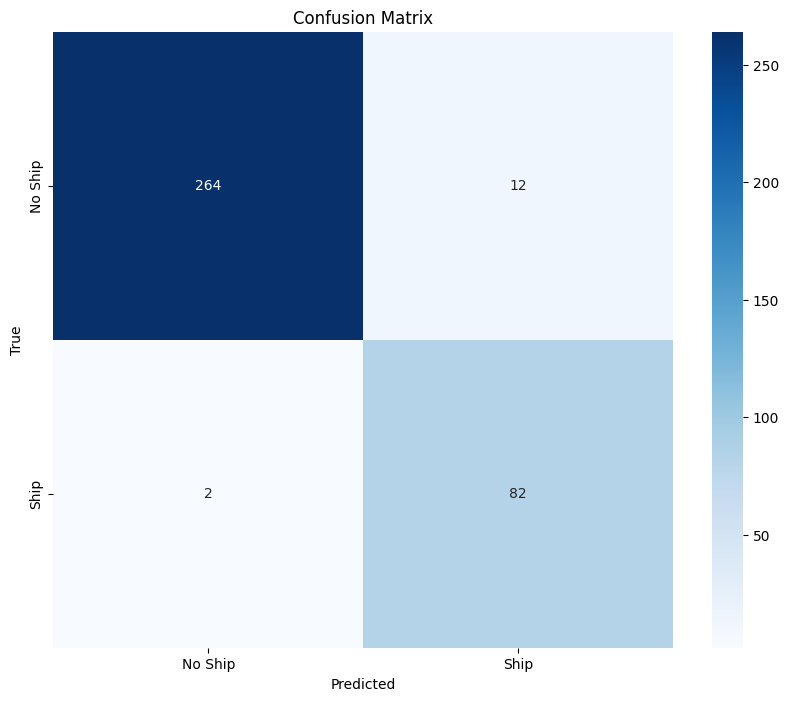

In [ ]:
model = tf.keras.models.load_model('ship_classifier_model2.h5')

# Re-compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])


# Evaluate the model on the test set
print(model.input_shape)
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

# Print detailed metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {test_precision:.2f}')
print(f'Test Recall: {test_recall:.2f}')

# Make predictions on the test set
# Use sigmoid thresholding for binary classification
y_pred_prob = model.predict(X_test)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Apply threshold for binary classification
y_true = y_test  # Assuming y_test is already in binary format (0 or 1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Set custom tick labels for the axes
ax.set_xticklabels(['No Ship', 'Ship'])  # Adjust labels as needed
ax.set_yticklabels(['No Ship', 'Ship'])  # Adjust labels as needed

plt.show()


## Test the model on the scene

In [ ]:
# Load the trained model
model = tf.keras.models.load_model('ship_classifier_model2.h5')

basepath = driveLocation  # Using the already defined drive location

# Stride value to move over the image
stride = 20

# List and load the scene file (assuming it follows the same naming pattern)
scene_list = glob(os.path.join(basepath, "sfbay_1*"))
scene_file = scene_list[0]

# Read the image (assuming it is already in RGB)
img = cv2.imread(scene_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape

# Create a figure to display the image
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)  # Display the original RGB image

# Loop over the image in strides of 20 and process 80x80 patches
for h in range(0, height - 80, stride):
    print("Step", int(h / stride), "of", int((height - 80) / stride))

    # Scan the entire image (from left to right, full width)
    for w in range(0, width - 80, stride):
        # Extract 80x80 patch from the RGB image
        img_box = img[h:h + 80, w:w + 80]

        # Convert the patch to grayscale
        img_box_gray = cv2.cvtColor(img_box, cv2.COLOR_RGB2GRAY)

        # Model might expect a 3D input, so stack grayscale to have 3 channels
        img_box_gray_3d = np.stack([img_box_gray] * 3, axis=-1)  # Grayscale to 3 channels

        # Add batch dimension
        img_box_gray_3d = np.array([img_box_gray_3d], dtype=np.float32)  # Adjust dtype if necessary

        # Get the prediction from the model
        prediction = model.predict(img_box_gray_3d, verbose=False)
        prediction_probability = np.max(prediction)
        prediction_class = np.argmax(prediction)

        # Draw a rectangle based on the predicted class and confidence
        if (prediction_class == 0 and prediction_probability > 0.95) or (prediction_class == 1 and prediction_probability < 0.05):
            ax.add_patch(patches.Rectangle((w, h), 80, 80, edgecolor='r', facecolor='none'))  # Red rectangle for detections
            # Uncomment the following line if you want to print out the detection information
            # print(f"Drawn rectangle at (h={h}, w={w}): Class={prediction_class}, Probability={prediction_probability:.4f}")

# Show the final image with the detected ships highlighted
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Train the model on Fuzzy C-means clusters

In [ ]:
#load images from the unlabeled dataset
unlabeled_dataset_folder = os.path.join(path, 'dataset.npz')
images, image_files = load_images_from_folder(unlabeled_dataset_folder)

In [ ]:
# Let's assume cluster 0 corresponds to 'no ship' and cluster 1 corresponds to 'ship'

#get the clusters
clusters = get_clusters(image_files, 'cluster_assignments_fcm.csv')

# Convert labels to a binary format (0 or 1)
labels = np.array(clusters)  # Cluster 0 as 'no ship', Cluster 1 as 'ship'


#count how many images are in each class
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the results
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} images")

Label 0: 1271 images
Label 1: 2729 images


### Get the dataset ready for training

In [ ]:
# Split the data into training and a temporary set for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)

# Create SMOTE object
smote = SMOTE(random_state=42)

# For SMOTE to work, your features need to be 2D. Flatten the images if they are 3D.
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Reshape to (num_samples, 80*80*3)

# Apply SMOTE to oversample the minority class
X_resampled, y_resampled = smote.fit_resample(X_train_flattened, y_train)

# Reshape the oversampled images back to their original dimensions
X_train_balanced = X_resampled.reshape(X_resampled.shape[0], 80, 80, 3)  # Reshape back to (num_samples, 80, 80, 3)

# Shuffle the balanced training set
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_resampled, random_state=42)

# Now split the temporary set into validation and test sets (70% val, 30% test of the temp set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)


print(f"Number of images in the validation set: {len(X_val)}")
print(f"Number of images in the testing set: {len(X_test)}")
print(f"Number of images in the training set: {len(X_train_balanced)}")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Normalize the images (scaling between 0 and 1)
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply normalization lazily on each batch
train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# Set the batch size and shuffle the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_balanced)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Number of images in the validation set: 840
Number of images in the testing set: 360
Number of images in the training set: 3818


### compile and train the model

In [ ]:
#compile the model
model = simple_CNN_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        K.clear_session()  # Clear session
        gc.collect()       # Run garbage collector

# Use the callback when training
model.fit(train_dataset, validation_data=val_dataset,
    epochs=100,
    callbacks=[ClearMemory()]
)
# Save the trained model
model.save('ship_classifier_model3.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 78, 78, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 78, 78, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 76, 76, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 34, 34, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         131,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,897 (698.82 KB)

 Trainable params: 178,705 (698.07 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.6407 - loss: 0.6180 - val_accuracy: 0.6881 - val_loss: 0.6567
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8058 - loss: 0.4058 - val_accuracy: 0.6881 - val_loss: 1.7601
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8999 - loss: 0.2488 - val_accuracy: 0.3131 - val_loss: 0.7231
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9172 - loss: 0.1879 - val_accuracy: 0.6881 - val_loss: 3.5966
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9484 - loss: 0.1448 - val_accuracy: 0.6952 - val_loss: 2.6787
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9521 - loss: 0.0986 - val_accuracy: 0.8536 - val_loss: 1.2068
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9585 - loss: 0.0970 - val_accuracy: 0.8452 - val_loss: 0.9354
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9774 - loss: 0.0582 -

## Evaluate the model

(None, 80, 80, 3)
Test Loss: 2.4363
Test Accuracy: 73.33%
Test Precision: 0.72
Test Recall: 1.00
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


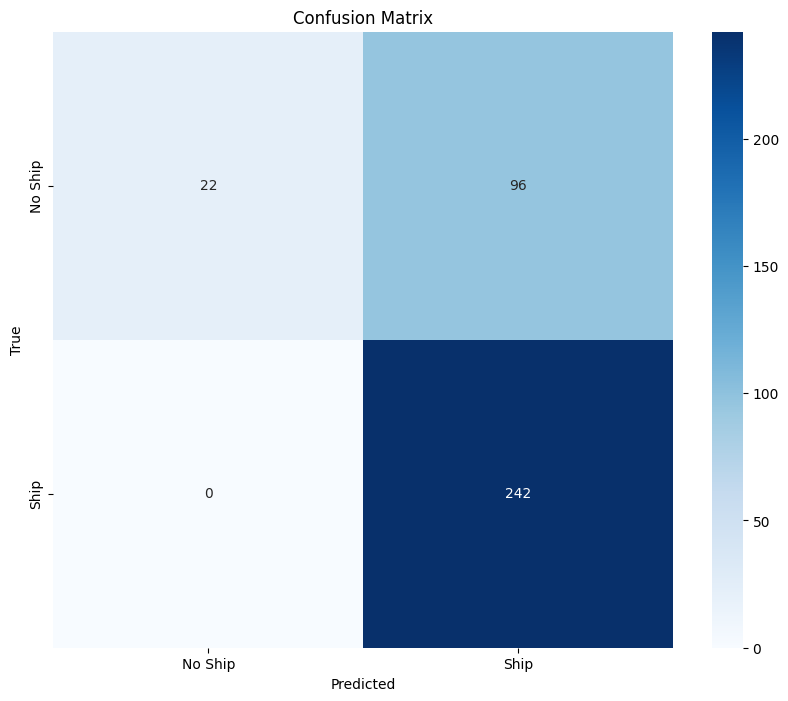

In [ ]:
model = tf.keras.models.load_model('ship_classifier_model3.h5')

# Re-compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])


# Evaluate the model on the test set
print(model.input_shape)
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

# Print detailed metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {test_precision:.2f}')
print(f'Test Recall: {test_recall:.2f}')

# Make predictions on the test set
# Use sigmoid thresholding for binary classification
y_pred_prob = model.predict(X_test)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Apply threshold for binary classification
y_true = y_test  # Assuming y_test is already in binary format (0 or 1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Set custom tick labels for the axes
ax.set_xticklabels(['Ship', 'No Ship'])  # Adjust labels as needed
ax.set_yticklabels(['Ship', 'No Ship'])  # Adjust labels as needed

plt.show()


## Test the model on the scene

In [ ]:
# Load the trained model
model = tf.keras.models.load_model('ship_classifier_model3.h5')

# Base path where your images are stored
basepath = driveLocation  # Using the already defined drive location

# Stride value to move over the image
stride = 20

# List and load the scene file (assuming it follows the same naming pattern)
scene_list = glob(os.path.join(basepath, "sfbay_1*"))
scene_file = scene_list[0]

# Read the image (assuming it is already in RGB)
img = cv2.imread(scene_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape

# Create a figure to display the image
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)  # Display the original RGB image

# Loop over the image in strides of 20 and process 80x80 patches
for h in range(0, height - 80, stride):
    print("Step", int(h / stride), "of", int((height - 80) / stride))

    # Scan the entire image (from left to right, full width)
    for w in range(0, width - 80, stride):
        # Extract 80x80 patch from the RGB image
        img_box = img[h:h + 80, w:w + 80]

        # Convert the patch to grayscale
        img_box_gray = cv2.cvtColor(img_box, cv2.COLOR_RGB2GRAY)

        # Model might expect a 3D input, so stack grayscale to have 3 channels
        img_box_gray_3d = np.stack([img_box_gray] * 3, axis=-1)  # Grayscale to 3 channels

        # Add batch dimension
        img_box_gray_3d = np.array([img_box_gray_3d], dtype=np.float32)  # Adjust dtype if necessary

        # Get the prediction from the model
        prediction = model.predict(img_box_gray_3d, verbose=False)
        prediction_probability = np.max(prediction)
        prediction_class = np.argmax(prediction)

        # Draw a rectangle based on the predicted class and confidence
        if (prediction_class == 0 and prediction_probability < 0.05) or (prediction_class == 1 and prediction_probability > 0.95):
            ax.add_patch(patches.Rectangle((w, h), 80, 80, edgecolor='r', facecolor='none'))  # Red rectangle for detections
            # Uncomment the following line if you want to print out the detection information
            # print(f"Drawn rectangle at (h={h}, w={w}): Class={prediction_class}, Probability={prediction_probability:.4f}")

# Show the final image with the detected ships highlighted
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# train with LVQ

In [ ]:
# import numpy as np
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# from imblearn.over_sampling import SMOTE
# from sklearn.utils import shuffle


# # Load images from the unlabeled dataset
# unlabeled_dataset_folder = os.path.join(path, 'unlabeled_dataset')
# # images, image_files = load_images_from_folder(unlabeled_dataset_folder)

# # Let's assume cluster 0 corresponds to 'no ship' and cluster 1 corresponds to 'ship'
# clusters = get_clusters(image_files, 'cluster_assignments_kmeans.csv')
# labels = np.array(clusters)  # Convert to numpy array for easier handling

# # Print class distribution
# unique_labels, counts = np.unique(labels, return_counts=True)
# for label, count in zip(unique_labels, counts):
#     print(f"Label {label}: {count} images")

# #  Split and Balance Data
# X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)

# # Create SMOTE object and balance the dataset
# smote = SMOTE(random_state=42)
# X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Reshape for SMOTE
# X_resampled, y_resampled = smote.fit_resample(X_train_flattened, y_train)
# X_train_balanced = X_resampled.reshape(X_resampled.shape[0], 80, 80, 3)  # Reshape back

# # Shuffle the balanced training set
# X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_resampled, random_state=42)

# # Split the temporary set into validation and test sets (70% val, 30% test)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

# # Define LVQ Model
# class LVQ(tf.keras.Model):
#     def __init__(self, num_prototypes, input_dim):
#         super(LVQ, self).__init__()
#         self.num_prototypes = num_prototypes
#         self.input_dim = input_dim
#         # Initialize prototypes for each class
#         self.prototypes = tf.Variable(tf.random.normal([num_prototypes, input_dim]), dtype=tf.float32)

#     def call(self, x):
#         # Calculate distances between input data and prototypes
#         distances = tf.norm(tf.expand_dims(x, axis=1) - self.prototypes, axis=2)
#         return tf.argmin(distances, axis=1)

#     def update_prototypes(self, x, y, learning_rate=0.1):
#         for i in range(self.num_prototypes):
#             # Get the data points assigned to the current prototype
#             assigned_points = x[y == i]
#             if assigned_points.shape[0] > 0:
#                 # Update the prototype to move towards the mean of assigned points
#                 new_prototype = tf.reduce_mean(assigned_points, axis=0)
#                 self.prototypes[i].assign((1 - learning_rate) * self.prototypes[i] + learning_rate * new_prototype)

#     def get_config(self):
#         config = super(LVQ, self).get_config()
#         config.update({
#             'num_prototypes': self.num_prototypes,
#             'input_dim': self.input_dim
#         })
#         return config

#     @classmethod
#     def from_config(cls, config):
#         return cls(config['num_prototypes'], config['input_dim'])

# # Step 4: Train the LVQ Model
# num_prototypes = 2  # Assuming binary classification (no ship, ship)
# lvq_model = LVQ(num_prototypes, X_train_balanced.shape[1] * X_train_balanced.shape[2] * X_train_balanced.shape[3])

# # Training Loop
# num_epochs = 20
# for epoch in range(num_epochs):
#     print(f'Epoch {epoch + 1}/{num_epochs}')

#     # Flatten images and ensure the input type is float32
#     X_train_flat = tf.convert_to_tensor(X_train_balanced.reshape(X_train_balanced.shape[0], -1), dtype=tf.float32)

#     # Assign data points to the nearest prototype
#     assignments = lvq_model(X_train_flat)

#     # Update the prototypes based on the assignments
#     lvq_model.update_prototypes(X_train_flat, y_train_balanced)

# # Step 5: Save the Model
# lvq_model_path = 'ship_classifier_model3.h5'
# lvq_model.save(lvq_model_path)

# # Step 6: Load the Model
# lvq_model_loaded = tf.keras.models.load_model(lvq_model_path, custom_objects={'LVQ': LVQ})

# # Step 7: Evaluate the Model
# # Flatten the test images and convert to float32
# X_test_flattened = tf.convert_to_tensor(X_test.reshape(X_test.shape[0], -1), dtype=tf.float32)  # Ensure it is float32
# test_assignments = lvq_model_loaded(X_test_flattened)

# # Calculate metrics
# conf_matrix = confusion_matrix(y_test, test_assignments.numpy())
# print(conf_matrix)

# # Step 8: Visualize Confusion Matrix
# plt.figure(figsize=(10, 8))
# ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# ax.set_xticklabels(['No Ship', 'Ship'])
# ax.set_yticklabels(['No Ship', 'Ship'])
# plt.show()

In [ ]:
# # Load the trained model
# model = tf.keras.models.load_model(lvq_model_path, custom_objects={'LVQ': LVQ})

# # Base path where your images are stored
# basepath = driveLocation  # Using the already defined drive location

# # Stride value to move over the image
# stride = 20

# # List and load the scene file (assuming it follows the same naming pattern)
# scene_list = glob(os.path.join(basepath, "sfbay_1*"))
# scene_file = scene_list[0]

# # Read and convert the image from BGR to RGB
# img = cv2.imread(scene_file)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# height, width, _ = img.shape

# # Create a figure to display the image
# plt.figure(figsize=(15, 15))
# ax = plt.subplot(1, 1, 1)
# ax.imshow(img)

# # Loop over the image in strides of 20 and process 80x80 patches
# for h in range(0, height - 80, stride):
#     print("Step", int(h / stride), "of", int((height - 80) / stride))

#     # Scan the entire image (from left to right, full width)
#     for w in range(0, width - 80, stride):  # Adjusted to scan the full width
#         img_box = img[h:h + 80, w:w + 80]
#         img_box = np.array([img_box], dtype=np.int64)  # Add batch dimension

#         # Get the prediction from the model
#         prediction = model.predict(img_box, verbose=False)
#         prediction_probability = np.max(prediction)
#         prediction_class = np.argmax(prediction)

#         # Draw a rectangle based on the predicted class and confidence
#         if (prediction_class == 0 and prediction_probability > 0.95) or (prediction_class == 1 and prediction_probability < 0.05):
#             ax.add_patch(patches.Rectangle((w, h), 80, 80, edgecolor='r', facecolor='none'))  # Red rectangle for detections

# # Show the final image with the detected ships highlighted
# plt.show()

# Test the models on the scene

In [ ]:
# Load the trained models
model_list = ['ship_classifier_model1.h5', 'ship_classifier_model2.h5', 'ship_classifier_model3.h5']
models = []

for model_path in model_list:
    model = tf.keras.models.load_model(model_path)
    models.append(model)

# # Load the third model with custom objects
# model3 = tf.keras.models.load_model('ship_classifier_model3.h5', custom_objects={'LVQ': LVQ})
# models.append(model3)

colors = ['red', 'green', 'blue']

# Stride value to move over the image
stride = 20

# List and load the scene file (assuming it follows the same naming pattern)
scene_list = glob(os.path.join(basepath, "sfbay_1*"))
scene_file = scene_list[0]

# Read the image (assuming it is already in RGB)
img = cv2.imread(scene_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, _ = img.shape

# Create a figure to display the image
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)  # Display the original RGB image

# Loop over the image in strides of 20 and process 80x80 patches
for h in range(0, height - 80, stride):
    print("Step", int(h / stride), "of", int((height - 80) / stride))

    for w in range(0, width - 80, stride):
        # Extract 80x80 patch from the RGB image
        img_box = img[h:h + 80, w:w + 80]

        # Convert the patch to grayscale
        img_box_gray = cv2.cvtColor(img_box, cv2.COLOR_RGB2GRAY)

        # Convert grayscale to 3 channels
        img_box_gray_3d = np.stack([img_box_gray] * 3, axis=-1)

        # Add batch dimension
        img_box_gray_3d = np.array([img_box_gray_3d], dtype=np.float32)

        # Loop through models for predictions
        for idx, model in enumerate(models):
            prediction = model.predict(img_box_gray_3d, verbose=False)
            prediction_probability = np.max(prediction)
            prediction_class = np.argmax(prediction)

            # Draw rectangle if condition is met
            if (prediction_class == 0 and prediction_probability > 0.95) or \
               (prediction_class == 1 and prediction_probability < 0.05):
                color = colors[idx % len(colors)]  # Cycle colors if models > colors
                ax.add_patch(patches.Rectangle((w, h), 80, 80, edgecolor=color, facecolor='none'))



plt.show()

Output hidden; open in https://colab.research.google.com to view.